In [1]:
###### from cad.calc.geo import Geo

class Loss(ABC):
    
    @abstractmethod
    def get_loss(self, geo):
        pass
    
class TargetNoteLoss(Loss):
    
    def __init__(self, targets):
        self.target_numbers=targets
        self.target_freqs=[note_to_freq(x) for x in targets]
        
    def get_loss(self, geo):
        try:
            peak, fft=didgmo_bridge(geo)
        except Exception:
            return 100000.0
        l=0.0
        if len(peak.impedance_peaks) < len(self.target_freqs):
            return 100000.0
        
        for i in range(len(self.target_freqs)):
            damping=1-(0.5*i/len(self.target_freqs))
            l1 = self.target_freqs[i] - peak.impedance_peaks[i]["freq"]
            l+=l1*l1*damping
        return l
    
    def get_frequencies(self):
        return self.target_freqs
    
    def __repr__(self):
        n=[ str(note_name(t)) + " (" + str(round(note_to_freq(t), 2)) + ")" for t in self.target_numbers]
        return ", ".join(n)
    

def vis(geo):
    DidgeVisualizer.vis_didge(geo)
    plt.show()
    peak, fft=didgmo_bridge(geo)
    FFTVisualiser.vis_fft_and_target(fft, loss.get_frequencies())
    plt.show()
    peak.print_impedance_peaks()    

loss=TargetNoteLoss([-31, -19, -12, -5])
print(loss)
#loss=TargetNoteLoss([-31])

bsp=BasicShapeParameters()

n_poolsize=10
n_explore_iterations=3000
n_finetune_iterations=300

mutator=Mutator(BasicShapeParameters(), loss, n_explore_iterations, n_poolsize=n_poolsize)
pbar=tqdm(total=n_explore_iterations + n_poolsize*n_finetune_iterations,  position=0, leave=True)
pbar.set_description("exploring")
mutator.mutate(pbar)

for m in mutator.pool:
    print(m["loss"])
    

pool_mutator=PoolMutator(mutator.get_pool(), loss, n_finetune_iterations, 0.1)
best_geo=pool_mutator.mutate()
vis(best_geo.make_geo())

D1 (73.42), D2 (146.83), A3 (220.0), E3 (329.63)


exploring:  25%|██▍       | 1489/6000 [00:37<01:39, 45.15it/s]

KeyboardInterrupt: 

exploring:  25%|██▍       | 1489/6000 [00:49<01:39, 45.15it/s]

In [5]:
[1,6,8,90,12]+3


TypeError: can only concatenate list (not "int") to list

In [24]:
pbar=tqdm(total=20,  position=0, leave=True)
pbar is None

  0%|          | 0/20 [00:02<?, ?it/s]


False

In [9]:
class PoolMutator:
    
    def __init__(self, pool, loss, n_iterations, learning_rate=1):
        self.pool=pool
        self.loss=loss
        self.n_iterations=n_iterations
        self.learning_rate=learning_rate
        
    def mutate(self):
        
        best_mutant=None
        best_loss=None
        
        pbar=tqdm(total=self.n_iterations*len(self.pool),  position=0, leave=True)
        for i_pool in range(len(self.pool)):
            father=self.pool[i_pool]
            mutator=Mutator(self.pool[i_pool], self.loss, self.n_iterations, self.learning_rate, 1)
            mutant, mutant_loss=mutator.mutate(pbar)

            if best_mutant == None or best_loss>mutant_loss:
                best_mutant=mutant
                best_loss=mutant_loss
                
        pbar.close()

        return best_mutant

pool_mutator=PoolMutator(mutator.get_pool(), loss, 500, 0.1)
best_geo=pool_mutator.mutate()
vis(best_geo.make_geo())

  0%|          | 0/5000 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute '_comparable'

In [208]:
f=note_to_freq(-31)
for i in range(1, 12):
    new_f=i*f
    note_i=int(freq_to_note(new_f))
    print(i, new_f, note_name(note_i))

1 73.41619197935188 D1
2 146.83238395870376 D2
3 220.24857593805564 A#3
4 293.6647679174075 D3
5 367.0809598967594 F#3
6 440.4971518761113 A4
7 513.9133438554632 B4
8 587.329535834815 C#4
9 660.7457278141669 E4
10 734.1619197935188 F4
11 807.5781117728707 G4


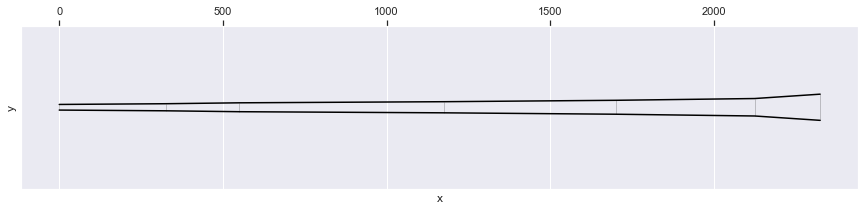

In [154]:
class BasicShapeParameters(MutationParameterSet):
    
    def __init__(self):
        super(BasicShapeParameters, self).__init__()
        
        #self.mutable_parameters.append(MutationParameter("length", 2500, 1800, 3000))
        self.mutable_parameters.append(MutationParameter("segment_width", 500, 400, 600))
        self.mutable_parameters.append(MutationParameter("n_segments", 5, 1, 10))
        self.mutable_parameters.append(MutationParameter("f", 0.6, 0.0, 1.0))     
        self.mutable_parameters.append(MutationParameter("bell_d", 1.5, 1.0, 2.5))
        self.mutable_parameters.append(MutationParameter("max_d", 80, 70, 150))
        self.mutable_parameters.append(MutationParameter("bell_x", 200, 100, 300))
        self.immutable_parameters.append(MutationParameter("d1", 32))
        
    def make_geo(self):
        shape=[
            [0, self.get("d1").value]
        ]

        f=self.get("f").value
        for i in range(self.get("n_segments").value):
            x_delta=1.25-(((f+2*i/10)*10)%10)/10
            x=shape[-1][0] + self.get("segment_width").value*x_delta
            d_delta=1.25+(((f+2*i/10)*10)%10)/1000
            d=shape[-1][1]*d_delta
            shape.append([x,d])
            i+=1
        
        shape.append([shape[-1][0] + self.get("bell_x").value, shape[-1][1]*self.get("bell_d").value])
        
        scaling=self.get("max_d").value / max([x[1] for x in shape])
        for i in range(len(shape)):
            shape[i][1]*=scaling
        return Geo(geo=shape)
                           
    def after_mutate(self):
        n_segments=int(self.get("n_segments").value)
        self.set("n_segments", n_segments)

geo=BasicShapeParameters().make_geo()
DidgeVisualizer.vis_didge(geo)
plt.show()
